## Overview

This script performs EDA and then preprocesses multiple datasets to train a bidirectional LSTM model which is in turn used to predict the sentiments behind tweets fetched in real time using `tweepy` and classify them as of positive in depression or negative in depression. The data has been taken from https://www.kaggle.com/code/ardawrld/twitter-sentiment-analysis-about-the-depression/input and then aggregated with other depression datasets.

## Installing and importing dependencies

We hev integrated 3 different datasets on depression. All the date from facebook anxiety comments page, has been labelled as 1 which menas Positive Depression

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import os
import tweepy as tw #for accessing Twitter API


#For Preprocessing
import re    # RegEx for removing non-letter characters
import nltk  #natural language processing
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *

# For Building the model
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns

#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

pd.options.plotting.backend = "plotly"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from google.colab import drive
import sys
drive.mount('/content/drive')
%cd "/content/drive/My Drive/Colab Notebooks/mental-health-codes"
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/mental-health-codes')
#import utilities as ut

%reload_ext autoreload
%autoreload 2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/mental-health-codes


In [3]:
!ls

 apple-twitter-sentiment-texts.csv
 best_model.h5
'Depression  Anxiety Facebook page Comments Text.csv'
'Depression  Anxiety Facebook page Comments Text.gsheet'
 Depression-detection-twitter-data.ipynb
 depression_text.csv
 finalSentimentdata2.csv
 Mental-health-data-classification-NLP.ipynb
 Mental-Health-sTwitter.csv
 Mental-Health-Twitter.csv
 model.png
 tokenizer.pickle
 Twitter_Data.csv
 twitter-sentiment-analysis-lstm.ipynb
 using-lstm-for-nlp-text-classification.ipynb


## Exploratory Data Analysis

### Cleaning and prepping dataset

In [4]:
# Load Tweet dataset
df1 = pd.read_csv('Mental-Health-Twitter.csv')
df1.rename(columns={"post_text": "clean_text", "label": "category"}, inplace=True)
# Output first five rows
dfn = df1[['clean_text', 'category']]
dfn.head()

,clean_text,category
0,It's just over 2 years since I was diagnosed w...,1
1,"It's Sunday, I need a break, so I'm planning t...",1
2,Awake but tired. I need to sleep but my brain ...,1
3,RT @SewHQ: #Retro bears make perfect gifts and...,1
4,It’s hard to say whether packing lists are mak...,1


In [5]:
# Load Tweet dataset
df2 = pd.read_csv('depression_text.csv')
df2 = df2.rename(columns={'post_text': 'clean_text', 'label':'category'})
# Output first five rows
df2, df2.head()

(                                             clean_text  category
 0                                  let Gather For Party       0.0
 1        I hate being alive when I feel so dead inside.       1.0
 2     Exam are Comimg I m already Feeling Very Depre...       1.0
 3                                          Nice picture       0.0
 4     Feeling worried, even though you actually have...       1.0
 ...                                                 ...       ...
 7484  "Nothing beats the feeling of achieving someth...       0.0
 7485                Too much homework Feeling Stressed!       1.0
 7486          overworked in school,, causes me headache       1.0
 7487  How come my friends immediately get to know st...       0.0
 7488                                toady I wake at 5am       0.0
 
 [7489 rows x 2 columns],
                                           clean_text  category
 0                               let Gather For Party       0.0
 1     I hate being alive when I feel so

The `category` column has 2 values:
1. 1 Indicating a Postive Depression
2. 0 Indicating a Negative Depression

In [6]:
# Load Tweet dataset
df3 = pd.read_csv('Depression  Anxiety Facebook page Comments Text.csv')
df3 = df3.rename(columns={'post_text': 'clean_text', 'label':'category'})
# Output first five rows
df3.head()

,clean_text,category
0,"So, when you ask what the two illnesses are......",1
1,"In addition, people with BPD quite often have ...",1
2,"Borderline Personality Disorder, like all othe...",1
3,LONG ANSWER: Bipolar disease is caused by a ch...,1
4,Well think of bipolar as a rollar coaster you ...,1


In [7]:
df = pd.concat([dfn, df2, df3], ignore_index=True)
# Map tweet categories
df['category'] = df['category'].map({0:'Negative', 1:'Positive'})
df.head(5), df.shape

(                                          clean_text  category
 0  It's just over 2 years since I was diagnosed w...  Positive
 1  It's Sunday, I need a break, so I'm planning t...  Positive
 2  Awake but tired. I need to sleep but my brain ...  Positive
 3  RT @SewHQ: #Retro bears make perfect gifts and...  Positive
 4  It’s hard to say whether packing lists are mak...  Positive,
 (34634, 2))

In [8]:
# Check for missing data
df.isnull().sum()

clean_text    13
category       3
dtype: int64

In [9]:
# drop missing rows
df.dropna(axis=0, inplace=True)

In [10]:
# dimensionality of the data
df.shape

(34621, 2)

In [11]:

df_new = df[(df.category == 'Positive') | (df.category == 'Negative')]

print(df.shape, df_new.category.unique())
df = df_new
# Output first five rows
df.head(), df.shape

(34621, 2) ['Positive' 'Negative']


(                                          clean_text  category
 0  It's just over 2 years since I was diagnosed w...  Positive
 1  It's Sunday, I need a break, so I'm planning t...  Positive
 2  Awake but tired. I need to sleep but my brain ...  Positive
 3  RT @SewHQ: #Retro bears make perfect gifts and...  Positive
 4  It’s hard to say whether packing lists are mak...  Positive,
 (34621, 2))

## Exploratory Data Analysis

Data Visualisation-

In [12]:
# The distribution of sentiments
df.groupby('category').count().plot(kind='bar')

Plotting the distribution of tweet lengths

In [13]:
# Calculate tweet lengths
tweet_len = pd.Series([len(tweet.split()) for tweet in df['clean_text']])

# The distribution of tweet text lengths
tweet_len.plot(kind='box')

Plotting the distribution of text length for positive sentiment tweets

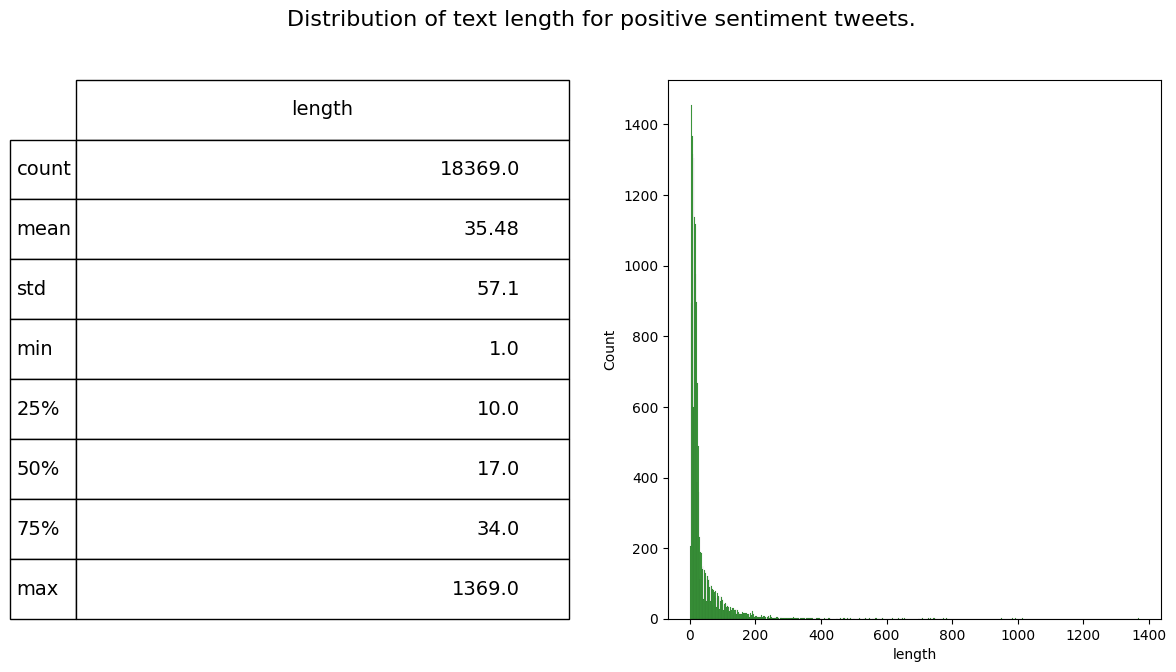

In [14]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.clean_text.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['category']=='Positive']['length'], ax=ax1,color='green')
describe = df.length[df.category=='Positive'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment tweets.', fontsize=16)

plt.show()

Plotting the Distribution of text length for Negative sentiment tweets.

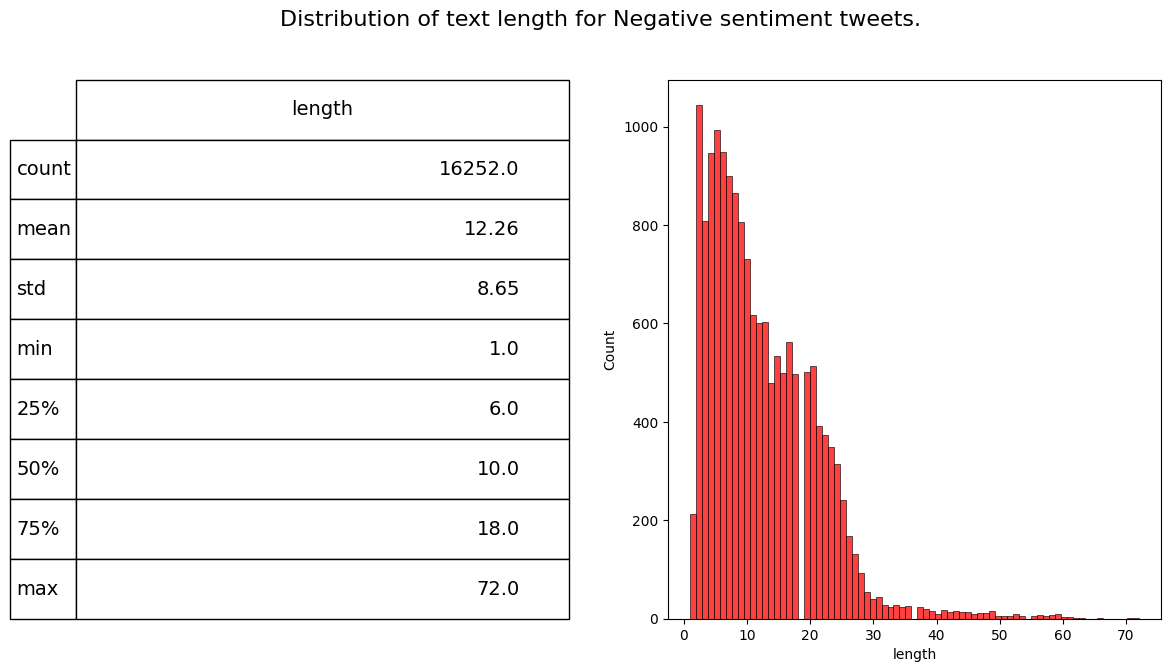

In [15]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.clean_text.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['category']=='Negative']['length'], ax=ax1,color='red')
describe = df.length[df.category=='Negative'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for Negative sentiment tweets.', fontsize=16)

plt.show()

Plotting the Pie chart of the percentage of different sentiments of all the tweets

In [16]:
import plotly.express as px
fig = px.pie(df, names='category', title ='Pie chart of different sentiments of tweets')
fig.show()

## Data Preprocessing

In [17]:
def tweet_to_words(tweet):
    ''' Convert tweet text into a sequence of words '''

    # convert to lowercase
    text = tweet.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

print("\nOriginal tweet ->", df['clean_text'][0])
print("\nProcessed tweet ->", tweet_to_words(df['clean_text'][0]))


Original tweet -> It's just over 2 years since I was diagnosed with #anxiety and #depression. Today I'm taking a moment to reflect on how far I've come since.

Processed tweet -> ['2', 'year', 'sinc', 'diagnos', 'anxieti', 'depress', 'today', 'take', 'moment', 'reflect', 'far', 'come', 'sinc']


In [18]:
# Apply data processing to each tweet
X = list(map(tweet_to_words, df['clean_text']))

In [19]:
from sklearn.preprocessing import LabelEncoder

# Encode target labels
le = LabelEncoder()
Y = le.fit_transform(df['category'])

In [20]:
print(X[0])
print(Y[0])

['2', 'year', 'sinc', 'diagnos', 'anxieti', 'depress', 'today', 'take', 'moment', 'reflect', 'far', 'come', 'sinc']
1


### Train and test split

In [21]:
y = pd.get_dummies(df['category'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

### Bag of words (BOW) feature extraction

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import TfidfVectorizer

vocabulary_size = 5000

# Tweets have already been preprocessed hence dummy function will be passed in
# to preprocessor & tokenizer step
count_vector = CountVectorizer(max_features=vocabulary_size,
#                               ngram_range=(1,2),    # unigram and bigram
                                preprocessor=lambda x: x,
                               tokenizer=lambda x: x)
#tfidf_vector = TfidfVectorizer(lowercase=True, stop_words='english')

# Fit the training data
X_train = count_vector.fit_transform(X_train).toarray()

# Transform testing data
X_test = count_vector.transform(X_test).toarray()

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



In [24]:
import sklearn.preprocessing as pr
# Normalize BoW features in training and test set
X_train = pr.normalize(X_train, axis=1)
X_test  = pr.normalize(X_test, axis=1)

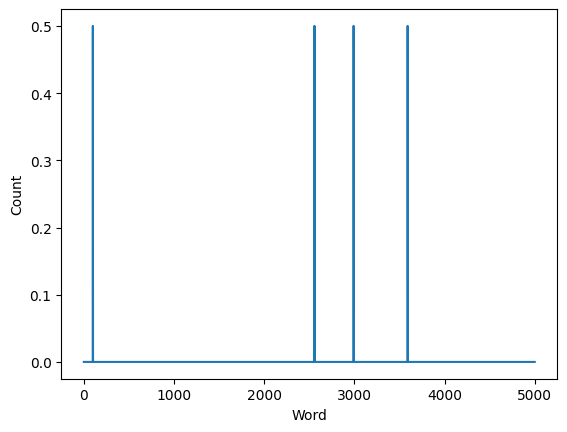

In [25]:
# Plot the BoW feature vector
plt.plot(X_train[2,:])
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

### Tokenizing & Padding

In [26]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df['clean_text'][0])
X, tokenizer = tokenize_pad_sequences(df['clean_text'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 It's just over 2 years since I was diagnosed with #anxiety and #depression. Today I'm taking a moment to reflect on how far I've come since.
After Tokenization & Padding 
 [ 34  32 140 134 106 236   1  29 281  19  44   3  52 222  28 207   6 605
   2  20  62 394  91 182 236   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


### Saving tokenized data

In [27]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

### Train & Test Split

In [28]:
y = pd.get_dummies(df['category'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (20772, 50) (20772, 2)
Validation Set -> (6924, 50) (6924, 2)
Test Set -> (6925, 50) (6925, 2)


In [29]:
import keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''

    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

## Bidirectional LSTM Using NN

In [30]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from keras.optimizers.legacy import SGD

from keras.optimizers import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses

vocab_size = 5000
embedding_size = 32
epochs=20
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/gradient_descent.py:114: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



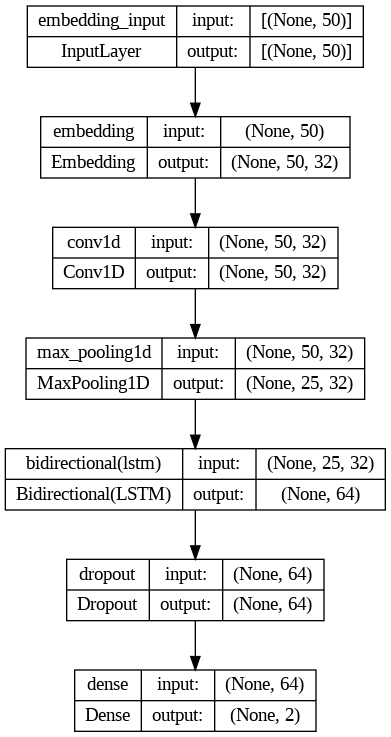

In [31]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

In [32]:
print(model.summary())

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=sgd,
               metrics=['accuracy', Precision(), Recall()])

# Train model

batch_size = 64
history = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=epochs, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 32)            160000    
                                                                 
 conv1d (Conv1D)             (None, 50, 32)            3104      
                                                                 
 max_pooling1d (MaxPooling1  (None, 25, 32)            0         
 D)                                                              
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 2)                 1

### Model Accuracy & Loss

In [33]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.8735
Precision : 0.8735
Recall    : 0.8735
F1 Score  : 0.8735


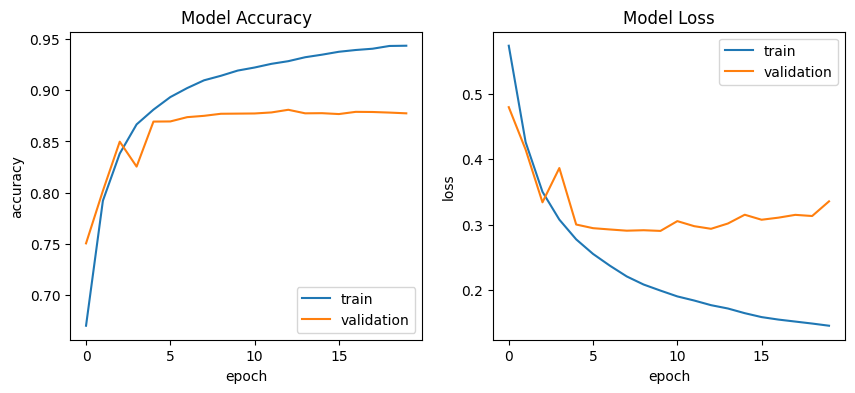

In [34]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''

    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')

plot_training_hist(history)

### Model Confusion Matrix

217/217 [==============================] - 2s 6ms/step


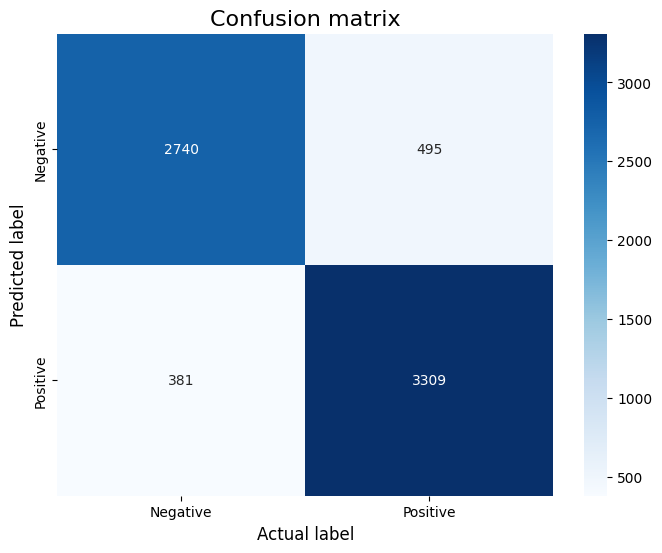

In [35]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''

    sentiment_classes = ['Negative', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d',
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)

plot_confusion_matrix(model, X_test, y_test)

### Model save and load for the prediction

In [36]:
# Save the model architecture & the weights
model.save('best_model.h5')
print('Best model saved')

Best model saved


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [37]:
from keras.models import load_model

# Load model
model = load_model('best_model.h5')

def predict_class(text):
    '''Function to predict sentiment class of the passed text'''

    sentiment_classes = ['Negative', 'Positive']
    max_len=50

    # Transforms text to a sequence of integers using a tokenizer object
    xt = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    # Do the prediction using the loaded model
    yt = model.predict(xt).argmax(axis=1)
    # Print the predicted sentiment
    print('The predicted sentiment is', sentiment_classes[yt[0]])

In [38]:
predict_class(['"Our teacher, professor Ulivi, was a nice guy. He could see I worked hard, and gave me a good grade, which he wrote down in a sort of passport each student had.'])

1/1 [==============================] - 2s 2s/step
The predicted sentiment is Positive


In [39]:
predict_class(['It seemed a good enough bet to be worth trying..'])

1/1 [==============================] - 0s 38ms/step
The predicted sentiment is Positive


In [45]:
predict_class(['college but it\'s like not going to college, its too boring and not interesting ...'])

1/1 [==============================] - 0s 52ms/step
The predicted sentiment is Negative
